# Introduction to Hoeffding Option Tree
The Hoeffding Option Tree (HOT) is an advanced variant of the Hoeffding Tree designed for online learning in data stream environments. Unlike traditional decision trees that require the entire dataset to be available at the start of training, Hoeffding Trees can incrementally update their structure as new data arrives, making them highly suitable for applications where data is continuously generated, such as in sensor networks, web analytics, and financial markets.

The Hoeffding Tree leverages the Hoeffding bound to decide when sufficient data has been seen at a node to make a statistically significant splitting decision. This bound ensures that with a high probability, the chosen split would be the same as if the node had been trained on an infinitely large dataset.

Building upon this concept, the Hoeffding Option Tree introduces additional flexibility and robustness by incorporating option nodes. These nodes allow multiple splitting paths from the same decision point, thereby creating a tree with multiple potential subtrees for each split which can be traversed in parallel. This capability enhances the tree’s ability to capture and adapt to complex patterns and variations within the data stream.

This study aims to implement an Hoeffding Option Tree classifier and integrate it into the [River](https://riverml.xyz) library, an advanced machine learning library designed specifically for online learning. Then is performed a comparative analysis among Hoeffding Option Tree implementation, the classical [Hoeffding Tree classifier](https://riverml.xyz/dev/api/tree/HoeffdingTreeClassifier/) implementation proposed by River and the offline [Decision Tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) from Scikit-Learn.  

<center>Hoffding Option Tree</center>
<center><img src="imgs/hot.png"></center>

# Implementative Choices

The construction of a Hoeffding Option Tree begins similarly to a Hoeffding Tree, where incoming data points are used to evaluate potential splits at each node. However, when a promising alternative split is detected, an option node is created, and both the original and alternative splits are traversed concurrently. This results in a tree with a richer and more complex structure, capable of maintaining multiple hypothesis paths simultaneously.

The fundamental component of the [Hoeffding Option Tree](https://link.springer.com/chapter/10.1007/978-3-540-76928-6_11) are the Option Nodes which, in this implementation, maintain a list of children nodes (subtrees which can be traversed in parallel) and a support leaf node. The inclusion of this support node allows to gather data and, if the condition on hoeffding bound are satisfied, split on the attributes in order to build a subtree. This subtree (which will be called `candidate_option_branch`)can be added to the Option Node's children (and thus to the overall tree) if the difference between its splitting value and the highest splitting value of the branches already added as children of the Option Node is within a specified threshold. This ensures to add only splits that offer substantial improvement are included. According to the original paper, the following pseudocode outlines the approach employed.

<center><img src="imgs/pseudocode.png" width="500"></center>

At the end, each leaf node effectively becomes an Option Node with no children but with a leaf as a candidate branch. This design maintains the structure of the tree while allowing for future expansions if new data justifies additional splits. In this way, each leaf node becomes an Option Node with no children but with a leaf as candidate branch. The figure below illustrates the approach employed in building incrementally an Hoeffding Option Tree using Option Nodes.

<center>Tree Building</center>
<center><img src="imgs/HOT-building.png"></center>

The parameters needed by this implementation of the Hoeffding Option Tree are 
* max options: maximum number of child that can be added to an Option Node. This limitation ensures that the tree remains manageable and prevents excessive growth in complexity. During the experiments $max\_options = 3$.
* $\delta'$: a parameter needed for deciding when to add another split option beneath an Option Node. According to the [original paper](https://link.springer.com/chapter/10.1007/978-3-540-76928-6_11), its value is computed as $ \delta' = exp(\alpha^2 \ln(\delta)) $, where
    * $\delta$ is the parameter used when computed the Hoeffding Inequality in the classical Hoeffding Tree implementation
    * $\alpha$ is a fraction of the original Hoeffding bound. During the experiments $\alpha = 0.05$ as in the original paper, that is decision 20 times more eager.

# Comparison

In this section is presented a comparative analysis between the performances of Hoeffding Option Tree classifier with the classical _Decision Tree_ classifier from scikit-learn library and the _Hoffding Tree_ classifier from the River library. This comparison is based on accuracy and computational efficiency.



In [2]:
import random
import numpy as np 
from sklearn.utils import Bunch
from sklearn import datasets
from sklearn.datasets import make_classification

# auxiliary function to rearrange dataset in order to inject concept drift
def inject_cd(dataset):

    X = dataset.data
    y = dataset.target
    indices_sorted = np.argsort(y)
        
    # Rearrange X and y based on sorted indices
    X_sorted = X[indices_sorted]
    y_sorted = y[indices_sorted]
    
    labels = np.unique(y_sorted)
    starting_idxs = [np.where(y_sorted == s)[0][0] for s in labels]
    i = [s for s in starting_idxs]
    X_out = np.zeros((0, X.shape[1]))
    y_out = np.array([])
    
    while len(X_out) < len(X):
        current_class_idx = np.random.randint(len(labels))
        current_i = i[current_class_idx]
        
        if ((current_class_idx == len(labels) - 1 and current_i == len(X_sorted)) or 
                (not current_class_idx == len(labels) - 1 and current_i >= starting_idxs[current_class_idx + 1])):
            continue
        bound = len(X) if current_class_idx == len(labels) - 1 else starting_idxs[current_class_idx + 1]
        n_samples = np.random.randint(3, 25)
        end_idx = np.min([current_i + n_samples, bound])
        
        X_out = np.concatenate([X_out, X_sorted[current_i:end_idx]])
        y_out = np.concatenate([y_out, current_class_idx * np.ones(end_idx - current_i)])
        i[current_class_idx] = end_idx
    
    dataset_cd = Bunch(
        data=X_out,
        target=y_out,
        feature_names=dataset.feature_names,
        target_names=dataset.target_names
    )
    return dataset_cd

X, y = make_classification(
    n_samples=500,
    n_features=6,
    n_informative=5,
    n_redundant=1,
    n_classes=3,
    random_state=42
)

iris = datasets.load_iris()
synthetic = Bunch(data=X, target=y, feature_names=[f'feature_{i}' for i in range(6)], target_names=['class'])
synthetic.DESCR = "Synthetic dataset with 5 features and 2 classes for online machine learning."
synthetic_cd = inject_cd(synthetic)

datasets = {"synthetic": synthetic, "synthetic-CD": synthetic_cd, "iris": iris}
n_datasets = len(datasets)
results = dict()

## Offline Decision Tree - Sklearn

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

results["Offline Decision Tree"] = dict()
for dataset_name in datasets:
    shuffle = not (dataset_name.endswith("CD"))
      
    dataset = datasets[dataset_name]
    X_train, X_test, y_train, y_test = train_test_split(
        dataset.data, dataset.target, test_size=0.3, stratify=(None if not shuffle else dataset.target), 
        random_state=42, shuffle=shuffle
    )
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    print(f'[{dataset_name}]\tModel accuracy: {accuracy:.4f}')
    
    results["Offline Decision Tree"][dataset_name] = dict(Accuracy=[accuracy], cm=cm)

[synthetic]	Model accuracy: 0.7533
[synthetic-CD]	Model accuracy: 0.7067
[iris]	Model accuracy: 0.9778


## Hoeffding Tree (River) and Hoeffding Option Tree

In [4]:
from river.tree import HoeffdingTreeClassifier
from hoeffding_option_tree import HoeffdingOptionTreeClassifier
from river.stream import iter_sklearn_dataset
from river.metrics import Accuracy
from river.evaluate import iter_progressive_val_score
import copy

if "results" not in locals():
    results = dict()

def reformat(generator) -> dict:
    out = dict()
    for el in generator:
        for key in el:
            value = copy.deepcopy(el[key])
            if key == "Time":
                value = round(value.total_seconds() * 1000, 3)
            elif key == "Memory":
                value = round(value / 1024, 2)
            elif key == "Accuracy":
                cm = value.cm
                value = value.get()
            if key in out:
                out[key].append(value)
            else:
                out[key] = [value]
    out["cm"] = cm
    return out

results["Hoeffding Tree"] = dict()
results["Hoeffding Option Tree"] = dict()
for dataset_name in datasets:
    shuffle = not (dataset_name.endswith("CD"))
    res = reformat(iter_progressive_val_score(dataset=iter_sklearn_dataset(datasets[dataset_name], shuffle=shuffle, seed=42), 
                                                           model=HoeffdingTreeClassifier(tau=1.5, grace_period=3), 
                                                           metric=Accuracy(), 
                                                           measure_memory=True, measure_time=True))
    results["Hoeffding Tree"][dataset_name] = res
    print(f'[Hoeffding Tree] on [{dataset_name}]\tModel accuracy: {res["Accuracy"][-1]:.4f}')
    
    res = reformat(iter_progressive_val_score(dataset=iter_sklearn_dataset(datasets[dataset_name], shuffle=shuffle, seed=42), 
                                                                  model=HoeffdingOptionTreeClassifier(tau=1.5, grace_period=3, max_options=3), 
                                                                  metric=Accuracy(), 
                                                                  measure_memory=True, measure_time=True))
    results["Hoeffding Option Tree"][dataset_name] = res
    print(f'[Hoeffding Option Tree] on [{dataset_name}]\tModel accuracy: {res["Accuracy"][-1]:.4f}')

[Hoeffding Tree] on [synthetic]	Model accuracy: 0.5491
[Hoeffding Option Tree] on [synthetic]	Model accuracy: 0.6774
[Hoeffding Tree] on [synthetic-CD]	Model accuracy: 0.6353
[Hoeffding Option Tree] on [synthetic-CD]	Model accuracy: 0.7054
[Hoeffding Tree] on [iris]	Model accuracy: 0.8859
[Hoeffding Option Tree] on [iris]	Model accuracy: 0.8993


## Results

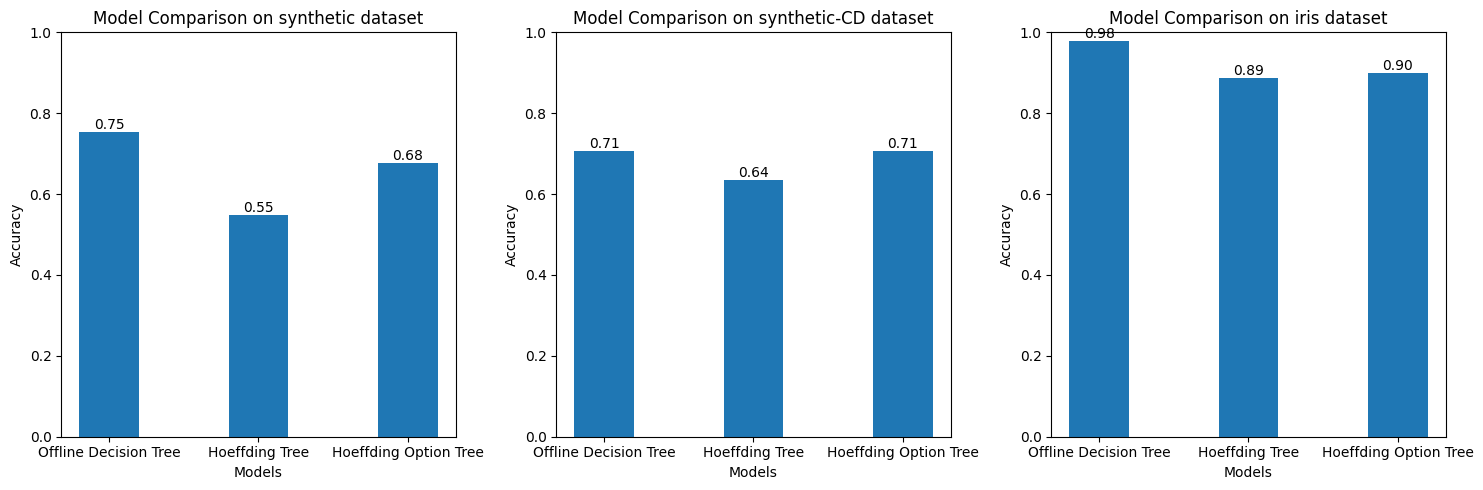

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, n_datasets, figsize=(15, 5))

for i, dataset_name in enumerate(datasets):

    data = {model: results[model][dataset_name]["Accuracy"][-1] for model in results}
    models = list(data.keys())
    values = list(data.values())
    
    bars = axs[i].bar(models, values, width=0.4)
    for bar in bars:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom')
    
    axs[i].set_xlabel("Models")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim(0, 1)
    axs[i].set_title(f"Model Comparison on {dataset_name} dataset")

plt.tight_layout()
plt.show()

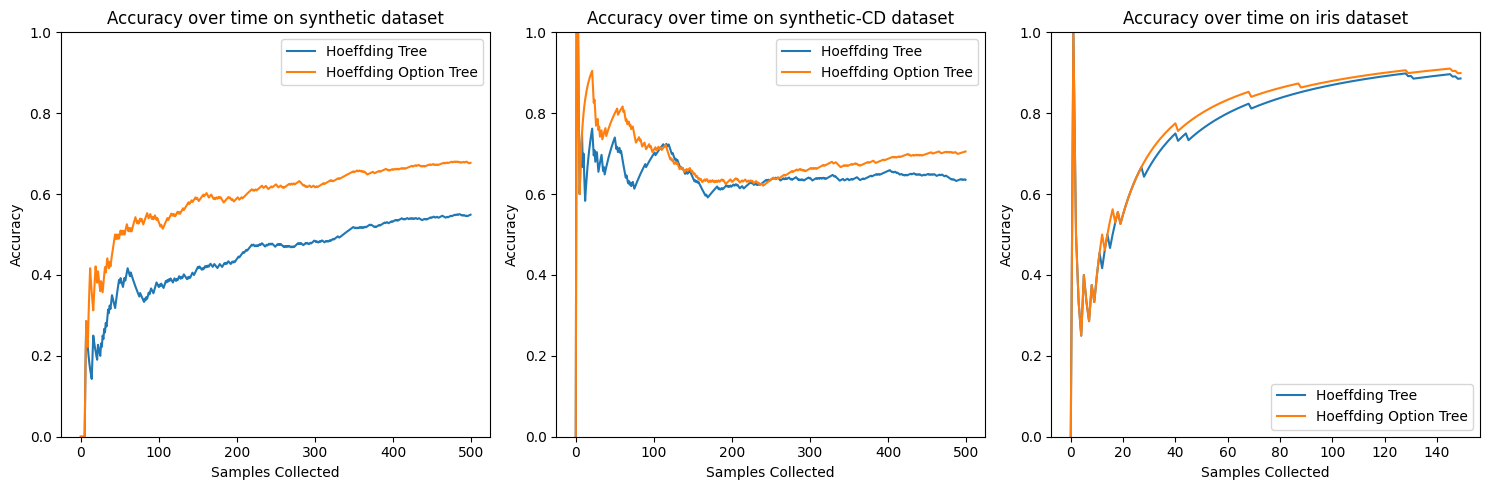

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, n_datasets, figsize=(15, 5))

for i, dataset_name in enumerate(datasets):
    
    for model in results:
        if len(results[model][dataset_name]["Accuracy"]) < 2:
            continue
        data = results[model][dataset_name]["Accuracy"]
        axs[i].plot(data, label=model)
    
    axs[i].legend()
    axs[i].set_title(f"Accuracy over time on {dataset_name} dataset")
    axs[i].set_xlabel("Samples Collected")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

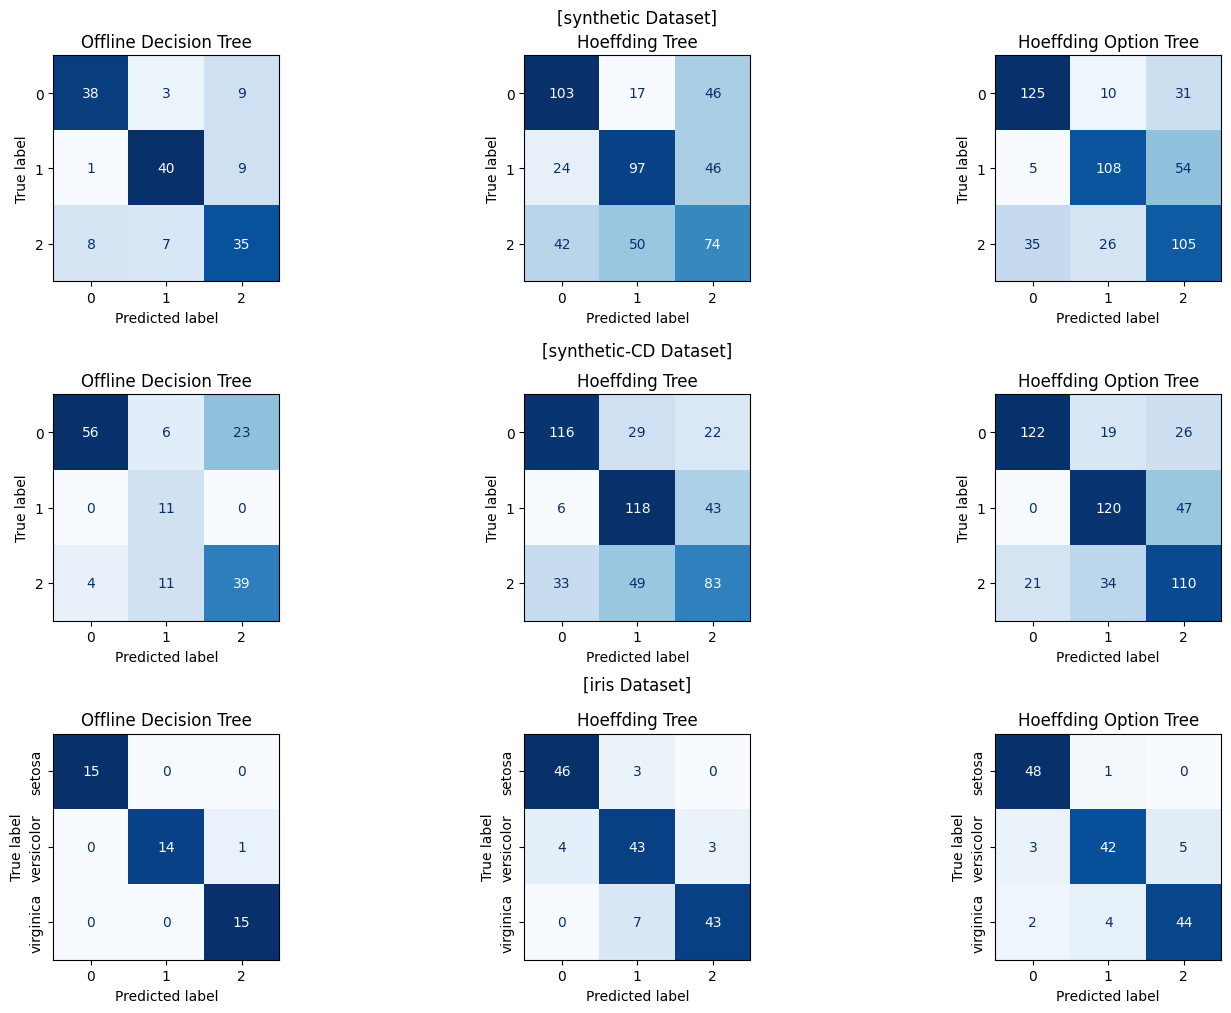

In [7]:
import river
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
label_mapping = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

n = len(results.keys())
fig, axs = plt.subplots(n_datasets, n, figsize=(15, 10))

for i, dataset_name in enumerate(datasets):
    
    for j, model in enumerate(results):
        cm = results[model][dataset_name]["cm"]
        # convert river.metrics.ConfusionMatrix to numpy.ndarray in order to be plotted by Sklearn.metrics.ConfusionMatrixDisplay
        if isinstance(cm, river.metrics.ConfusionMatrix):
            labels = list(cm.classes)
            cm = np.array([[cm[x][y] for y in labels] for x in labels])
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axs[i, j], cmap=plt.cm.Blues, colorbar=False,  values_format = '.0f')
        if dataset_name == "iris":
            axs[i, j].set_yticklabels(list(map(label_mapping.get, label_mapping.keys())), rotation=90, va="center")
        axs[i, j].set_title(model)
    
for i, dataset_name in enumerate(datasets):
    fig.text(0.5, 1 - (i) / n_datasets, f"[{dataset_name} Dataset]", ha='center', va='center', fontsize='large')


plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase the value to add more vertical space
plt.show()

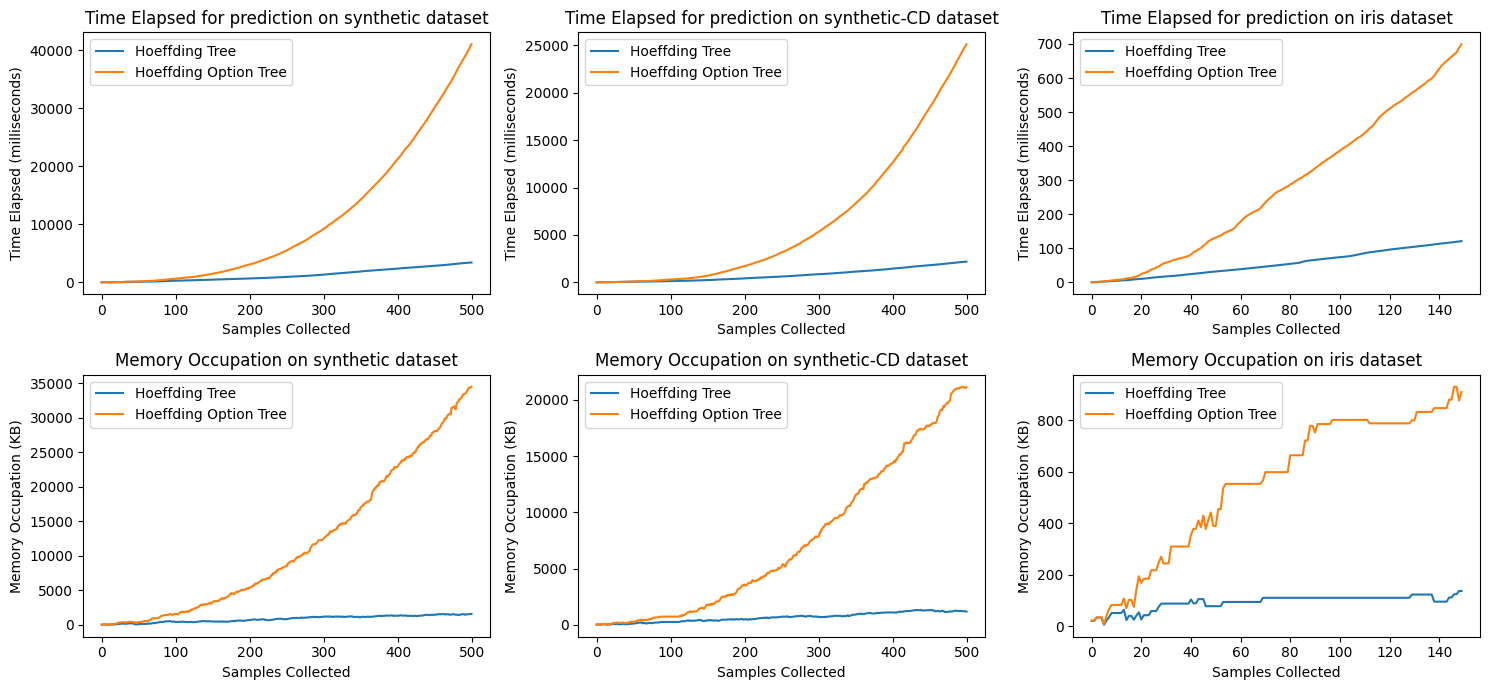

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, n_datasets, figsize=(15, 7))

for i, dataset_name in enumerate(datasets):
    
    for model_name in results:
        if "Time" not in results[model_name][dataset_name] or "Memory" not in results[model_name][dataset_name]:
            continue
    
        data = results[model_name][dataset_name]["Time"]
        axs[0, i].plot(data, label=model_name)
        
        data = results[model_name][dataset_name]["Memory"]
        axs[1, i].plot(data, label=model_name)
     
    axs[0, i].legend()
    axs[0, i].set_title(f"Time Elapsed for prediction on {dataset_name} dataset")
    axs[0, i].set_xlabel("Samples Collected")
    axs[0, i].set_ylabel("Time Elapsed (milliseconds)")
    
    axs[1, i].legend()
    axs[1, i].set_title(f"Memory Occupation on {dataset_name} dataset")
    axs[1, i].set_xlabel("Samples Collected")
    axs[1, i].set_ylabel("Memory Occupation (KB)")

plt.tight_layout()
plt.show()

# Conclusions and Future Works

The results of this comparative analysis clearly indicate that the Hoeffding Option Tree Classifier generally outperforms the classical Hoeffding Tree Classifier in terms of accuracy. This improvement in performance can be justified by the increased complexity of the tree, which incorporates multiple paths for inference by adding option nodes, leading to more accurate prediction. Moreover, a very interesting improvement (in terms of accuracy) comes when dealing with dataset which suffers from Concept Drift, resulting the Hoeffding Option Tree is better at modeling those kinds of dataset.

However, this enhanced accuracy comes at a significant cost in terms of computational complexity. The high number of branches attached to Option Nodes imply traversing multiple paths during a single inference, resulting in increased computational time and memory usage. From the plots, we can see that both time and space complexities of Hoeffding Option Tree Classifier grow exponentially w.r.t. the classical Hoeffding Tree Classifier. 

So, even if this implementation of Hoeffding Option Tree is more accurate than the classical Hoeffding Tree, the main issue resides in the latency since it's the most important requirements in online machine learning: in most of the cases we can accept to lose some points on accuracy while improving a lot in speed.  

However, this is just a simple implementation of Hoeffding Option Tree which presents both a challenge and an opportunity for further optimization. A first improvement relies on implement a pruning technique in order to remove branches that contribute little to no improvement in decision-making: this can reduce model's complexity, decreasing space occupation and so latency. Moreover, concurrent traversing can be exploited in order to visit different branches in parallel at the same time. Then, if these two main issues can be mitigated making the model's complexity linear w.r.t. the samples collected, the usage of Hoeffding Option Tree can lead to performance improvement in the context of online machine learning.